<a href="https://colab.research.google.com/github/thomasbeck95/CTM/blob/main/GPRankingAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# set up
import pandas as pd
import numpy as np

## Generate ficticious ranking data
Define a function to imitate a clinician assigning a priority score to each task. Then simulate providing sets of tasks to the clinician, apply scoring function and rank. Task + rank will act as the inputs to a ranking algorithm

In [2]:
# define clinicians A opinions
medication_type_ranking_a = {
    'Insulin' : 3,
    'Anti-Epileptics' : 3,
    'Immunosuppressants' : 3,
    'Anti-Hypertension' : 2,
    'Statins' : 2,
    'SSRIs' : 2,
    'Vitamins' : 1,
    'Emollients' : 1,
    'Mild Pain Relief' : 1
    }
prescription_request_source_ranking_a = {
    "Out-of-hours GP" : 3,
    "Pharmacist" : 3,
    "Phone" : 2,
    "Routine request via online" : 2,
    "NHS app" : 2,
    "Routine scheduled repeats" : 1

}
investigation_source_ranking_a = {
    "Out-of-hours GP" : 3,
    "Pharmacist" : 3,
    "Phone" : 2,
    "Routine request via online" : 2,
    "NHS app" : 2,
    "Routine scheduled repeats" : 1

}
medication_urgency_ranking_a = {
    "<1 day supply" : 3,
    ">1 and <=3 days supply" : 1,
    ">3 days supply" : 0.5
}

comorbidities_ranking_a = {
    "Epilepsy" : 3,
    "Historical Heart Attack or Stroke" : 3,
    "Diabetes" : 2,
    "Mental Health" : 1
}

blood_results_limits = {
    'K+'  : {'LimitType' : 'Upper', 'LimitValue' : 6},
    'eGFR' : {'LimitType' : 'Lower', 'LimitValue' : 15},
    'PSA' : {'LimitType' : 'Upper', 'LimitValue' : 100},
    'Hb' : {'LimitType' : 'Lower', 'LimitValue' : 70},
    'INR' : {'LimitType' : 'Upper', 'LimitValue' : 8}
}

blood_results_rankings_a = {
    'K+'  : 2,
    'eGFR' : 2,
    'PSA' : 1,
    'Hb' : 1,
    'INR' : 1
}

ecg_reason_ranking_a = {
    'Suspected Heart Attack' : 3,
    'Suspected Coronary Heart Disease' : 2,
    'Suspected Arrythmia' : 1,
    'Screening for Medication' : 0.5
}

xray_region_ranking_a = {
    'Lower Limbs' : 0.5,
    'Upper Limbs' : 1,
    'Spine and Neck' : 2,
    'Torso' : 2,
    'Head' : 3
}

other_task_ranking_a = {'SickNotes' : 0.1, 'ReferralLetters' : 0.1, 'MedicalReports' : 0.1}

In [3]:
# function to simulate a doctors priority scoring
def score_task(task_type,
               medication_type = np.nan, medication_type_ranking = np.nan,
               medication_urgency = np.nan, medication_urgency_ranking = np.nan,
               prescription_request_source = np.nan, prescription_request_source_ranking = np.nan,
               monitoring_required = np.nan, monitoring_required_weighting = np.nan,
               polypharmacy = np.nan, polypharmacy_weighting = np.nan,
               investigation_type = np.nan,
               investigation_source = np.nan, investigation_source_ranking = np.nan,
               blood_results = np.nan, blood_results_limits = np.nan, blood_results_ranking = np.nan,
               comorbidities = np.nan, comorbidities_ranking = np.nan,
               xray_region = np.nan, xray_ranking = np.nan,
               ecg_reason = np.nan, ecg_reason_ranking = np.nan,
               other_task_ranking = np.nan,
               time_in_pipeline = np.nan, time_in_pipeline_weight = np.nan
               ):
  # apply different logic depending on the task type
  task_severity = 0

  if task_type == 'PrescriptionRequest':
    # assess which type of medication type
    medication_severity = medication_type_ranking[medication_type]
    # assess how long until out of medicine
    medication_urgency_severity = medication_urgency_ranking[medication_urgency]
    # assess whats the source of the request
    prescription_request_source_severity = prescription_request_source_ranking[prescription_request_source]
    # assess whether monitoring required
    if monitoring_required:
      monitoring_required_severity = monitoring_required_weighting
    else:
      monitoring_required_severity = 0
    # assess whether polypharmacy
    if polypharmacy:
      polypharmacy_severity = polypharmacy_weighting
    else:
      polypharmacy_severity = 0
    # combine into overall task severity
    task_severity = medication_severity + medication_urgency_severity + prescription_request_source_severity + monitoring_required_severity + polypharmacy_severity

  elif task_type == 'ReviewResults':
    # if an xray, assign severity based on region only
    if investigation_type == 'X-ray':
      task_severity = xray_ranking[xray_region]
    # if blood test, assign severity based on whether limits exceeded and clinician perspectives
    elif investigation_type == 'Blood Test':
      blood_test_score = 0
      # for each blood result, test if its under lower limit or over upper limit
      for test, result in blood_results.items():
        limit_value = blood_results_limits[test]['LimitValue']
        if blood_results_limits[test]['LimitType'] == 'Lower':
          if result < limit_value:
            blood_test_score += blood_results_ranking[test]
        elif blood_results_limits[test]['LimitType'] == 'Upper':
          if result > limit_value:
            blood_test_score += blood_results_ranking[test]
      task_severity = blood_test_score

    # if ECG, assign severity based on clinician perspective
    elif investigation_type == 'ECG':
      task_severity = ecg_reason_ranking[ecg_reason]
    task_severity += investigation_source_ranking[investigation_source]

  elif task_type == 'PatientCommunication':
    medication_severity = 0

  elif task_type == 'SickNotes':
    task_severity = other_task_ranking['SickNotes']

  elif task_type == 'ReferralLetters':
    task_severity = other_task_ranking['ReferralLetters']

  elif task_type == 'MedicalReports':
    task_severity = other_task_ranking['MedicalReports']


  # assess which comorbodities are present
  comorbidity_severity = 0
  for comorbidity in comorbidities:
    comorbidity_severity += comorbidities_ranking[comorbidity]

  # assess time in pipeline
  timing_severity = (time_in_pipeline ** 2) * time_in_pipeline_weight

  return task_severity + comorbidity_severity + timing_severity





In [4]:
# generate task inputs
## define available values
task_types = ['PrescriptionRequest', 'ReviewResults', 'PatientCommunication', 'SickNotes', 'ReferralLetters', 'MedicalReports']
medication_types = ['Insulin', 'Anti-Epileptics', 'Immunosuppressants', 'Anti-Hypertension', 'Statins', 'SSRIs', 'Vitamins', 'Emollients', 'Mild Pain Relief']
medication_urgencies = ['<1 day supply', '>1 and <=3 days supply', '>3 days supply']
prescription_request_sources = ["Out-of-hours GP", "Pharmacist", "Phone", "Routine request via online", "NHS app", "Routine scheduled repeats"]
investigation_types = ['X-ray', 'Blood Test', 'ECG']
investigation_sources = ['Out-of-hours GP', 'Pharmacist', 'Phone', 'Routine request via online', 'NHS app', 'Routine scheduled repeats']
comorbidities = ['Epilepsy', 'Historical Heart Attack or Stroke', 'Diabetes', 'Mental Health']
xray_regions = ['Lower Limbs', 'Upper Limbs', 'Spine and Neck', 'Torso', 'Head']
ecg_reasons = ['Suspected Heart Attack', 'Suspected Coronary Heart Disease', 'Suspected Arrythmia', 'Screening for Medication']

def generate_task(task_types, task_probabilities = None):
  # initialise task dictionary
  task_dict = {}
  # identify which task type
  task_type = np.random.choice(task_types, p = task_probabilities)
  task_dict['task_type'] = task_type
  if task_type == 'PrescriptionRequest':
    # randomise value
    medication_type = np.random.choice(medication_types)
    medication_urgency = np.random.choice(medication_urgencies)
    prescription_request_source = np.random.choice(prescription_request_sources)
    monitoring_required = np.random.choice([True, False], p = [0.1, 0.9])
    polypharmacy = np.random.choice([True, False], p = [0.1, 0.9])
    # add to dictionary
    task_dict['medication_type'] = medication_type
    task_dict['medication_urgency'] = medication_urgency
    task_dict['prescription_request_source'] = prescription_request_source
    task_dict['monitoring_required'] = monitoring_required
    task_dict['polypharmacy'] = polypharmacy
  elif task_type == 'ReviewResults':
    # randomise values
    investigation_type = np.random.choice(investigation_types)
    if investigation_type == 'X-ray':
      xray_region = np.random.choice(xray_regions)
      task_dict['xray_region'] = xray_region
    elif investigation_type == 'Blood Test':
      blood_results = blood_results = {
          'K+' : max([0, np.random.normal(3, 1.5)]),
          'eGFR' : max([0, np.random.normal(20, 5)]),
          'PSA' : max([0, np.random.normal(60, 10)]),
          'Hb' : max([0, np.random.normal(85, 5)]),
          'INR' : max([0, np.random.normal(3, 2)])
      }
      task_dict['blood_results'] = blood_results
      task_dict.update(blood_results)
    elif investigation_type == 'ECG':
      ecg_reason = np.random.choice(ecg_reasons)
      task_dict['ecg_reason'] = ecg_reason

    investigation_source = np.random.choice(investigation_sources)
    # add to dictionary
    task_dict['investigation_type'] = investigation_type
    task_dict['investigation_source'] = investigation_source

  elif task_type == 'PatientCommunication':
    pass
  elif task_type == 'SickNotes':
    pass
  elif task_type == 'ReferralLetters':
    pass
  elif task_type == 'MedicalReports':
    pass

  # identify comorbidities
  for combordity in comorbidities:
    has_combordity = np.random.choice([True, False], p = [0.1, 0.9])
    if has_combordity:
      task_dict[combordity] = 1
    else:
      task_dict[combordity] = 0
  # specify time in pipeline
  time_in_pipeline = np.random.gamma(1,2)
  task_dict['time_in_pipeline'] = time_in_pipeline
  # return dictionary
  return task_dict

In [5]:
# generate ficticious data
all_tasks = []
num_samples = 1000
for _ in range(num_samples):
  this_task = generate_task(task_types, task_probabilities = [0.3, 0.3, 0.1, 0.05, 0.05, 0.2])
  all_tasks.append(this_task)
all_tasks_df = pd.DataFrame(all_tasks)
display(all_tasks_df)

,task_type,blood_results,K+,eGFR,PSA,Hb,INR,investigation_type,investigation_source,Epilepsy,...,Diabetes,Mental Health,time_in_pipeline,xray_region,ecg_reason,medication_type,medication_urgency,prescription_request_source,monitoring_required,polypharmacy
0,ReviewResults,"{'K+': 1.1046300845546608, 'eGFR': 17.20724297...",1.10463,17.207243,54.640183,90.062091,3.664711,Blood Test,Phone,0,...,0,0,4.490193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ReviewResults,NaN,NaN,NaN,NaN,NaN,NaN,X-ray,NHS app,0,...,0,0,1.794511,Head,NaN,NaN,NaN,NaN,NaN,NaN
2,MedicalReports,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0.566214,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MedicalReports,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,3.241617,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MedicalReports,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0.705981,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,MedicalReports,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,2.122394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,MedicalReports,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,1.416822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,MedicalReports,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,1.717971,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,PrescriptionRequest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,2.184738,NaN,NaN,Anti-Epileptics,<1 day supply,Routine scheduled repeats,False,False


In [6]:
# apply ranking based on clinicians opinions
all_tasks_df['task_severity_a'] = all_tasks_df.apply(lambda x: score_task(task_type=x['task_type'],
                                                                          medication_type = x['medication_type'],
                                                                          medication_type_ranking = medication_type_ranking_a,
                                                                          medication_urgency = x['medication_urgency'],
                                                                          medication_urgency_ranking = medication_urgency_ranking_a,
                                                                          prescription_request_source = x['prescription_request_source'],
                                                                          prescription_request_source_ranking = prescription_request_source_ranking_a,
                                                                          monitoring_required = x['monitoring_required'],
                                                                          monitoring_required_weighting = 0.1,
                                                                          polypharmacy = x['polypharmacy'],
                                                                          polypharmacy_weighting = 0.3,
                                                                          investigation_type = x['investigation_type'],
                                                                          investigation_source = x['investigation_source'],
                                                                          investigation_source_ranking = investigation_source_ranking_a,
                                                                          blood_results = x['blood_results'],
                                                                          blood_results_limits = blood_results_limits,
                                                                          blood_results_ranking = blood_results_rankings_a,
                                                                          comorbidities = x[comorbidities][x[comorbidities] == 1].index.to_list(),
                                                                          comorbidities_ranking = comorbidities_ranking_a,
                                                                          xray_region = x['xray_region'],
                                                                          xray_ranking = xray_region_ranking_a,
                                                                          ecg_reason = x['ecg_reason'],
                                                                          ecg_reason_ranking = ecg_reason_ranking_a,
                                                                          other_task_ranking = other_task_ranking_a,
                                                                          time_in_pipeline = x['time_in_pipeline'],
                                                                          time_in_pipeline_weight = 0.1
                                                                            ), axis = 1)


In [7]:
all_tasks_df['task_severity_a'].describe()

,task_severity_a
count,1.000000e+03
mean,4.413852e+00
std,3.561825e+00
min,1.557557e-07
25%,1.510766e+00
50%,4.003938e+00
75%,6.578065e+00
max,2.988780e+01


In [8]:
# set a id column
all_tasks_df.reset_index(inplace = True)
all_tasks_df.rename(columns = {'index' : 'task_id'}, inplace = True)

In [9]:
# bootstrap dataset and rank according to this clinicians preference
rank_set_size = 5
n_bootstraps = 100
ranking_results = []
for n in range(n_bootstraps):
  subsample = all_tasks_df.sample(n = rank_set_size, replace = False) # dont want to compare task to itself
  subsample_sorted = subsample.sort_values(by = 'task_severity_a', ascending = False).reset_index(drop = True)
  subsample_sorted['Ranking'] = subsample_sorted.index + 1
  subsample_sorted['Group'] = n
  ranking_results.append(subsample_sorted)


In [94]:
ranking_results_df = pd.concat(ranking_results)
index_var = 'task_id'
ranking_results_df.set_index(index_var, inplace = True)

In [103]:
# train a pairwise ranking model
from sklearn.model_selection import train_test_split
from xgboost import XGBRanker
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit

## encode categorical features
categorical_features = ['task_type', 'medication_type', 'medication_urgency', 'prescription_request_source', 'investigation_type', 'investigation_source', 'xray_region', 'ecg_reason']
numeric_features = ['time_in_pipeline', 'K+', 'eGFR', 'PSA', 'Hb','INR']
boolean_features = ['monitoring_required', 'polypharmacy', 'Epilepsy', 'Historical Heart Attack or Stroke', 'Diabetes', 'Mental Health']
exclude_cols = ['blood_results', 'task_severity_a']
target = 'Ranking'
grouping_var = 'Group'



ranking_results_df = ranking_results_df.sort_values(grouping_var)
X = ranking_results_df.drop(columns = [*exclude_cols, target, grouping_var])
y = ranking_results_df[target]
groups = ranking_results_df[grouping_var]#.groupby(grouping_var)[grouping_var].count().values

# test train split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]
groups_test = groups.iloc[test_idx]


preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), numeric_features),  # Scale numeric features
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)  # Encode categorical
])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)



In [104]:
# Train XGBoost Ranker Model
model = XGBRanker(
    objective="rank:pairwise",
    learning_rate=0.1,
    max_depth=4,
    n_estimators=100,
    random_state=42
)

model.fit(X_train_transformed, y_train, qid = groups_train)


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None, learning_rate=0.1,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=4, max_leaves=None,
          min_child_weight=None, missing=nan, monotone_constraints=None,
          multi_strategy=None, n_estimators=100, n_jobs=None,
          num_parallel_tree=None, objective='rank:pairwise', ...)

In [105]:
# Evaluate on Test Data
y_pred = model.predict(X_test_transformed)


# Print Predictions
print("\n🔍 Predicted Rankings on Test Data:")
ranking_prediction_df = pd.concat([X_test, y_test, groups_test], axis = 1)
ranking_prediction_df['PredictedRankingScore'] = y_pred
ranking_prediction_df["PredictedRank"] = ranking_prediction_df.groupby(grouping_var)["PredictedRankingScore"].transform(lambda x: x.rank(method="dense", ascending=True))

display(ranking_prediction_df)
    #print(f"Task: {task['task_id']} | True Rank: {true_rank} | Predicted Rank: {pred_rank:.2f}")


🔍 Predicted Rankings on Test Data:


,task_type,K+,eGFR,PSA,Hb,INR,investigation_type,investigation_source,Epilepsy,Historical Heart Attack or Stroke,...,ecg_reason,medication_type,medication_urgency,prescription_request_source,monitoring_required,polypharmacy,Ranking,Group,PredictedRankingScore,PredictedRank
task_id,,,,,,,,,,,,,,,,,,,,,
325,MedicalReports,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1.375145,5.0
207,ReviewResults,NaN,NaN,NaN,NaN,NaN,ECG,Out-of-hours GP,0,0,...,Suspected Coronary Heart Disease,NaN,NaN,NaN,NaN,NaN,2,0,-0.575288,1.0
757,ReviewResults,NaN,NaN,NaN,NaN,NaN,ECG,Routine scheduled repeats,0,0,...,Suspected Heart Attack,NaN,NaN,NaN,NaN,NaN,3,0,-0.517649,2.0
687,ReviewResults,NaN,NaN,NaN,NaN,NaN,ECG,Pharmacist,0,0,...,Screening for Medication,NaN,NaN,NaN,NaN,NaN,4,0,-0.384674,3.0
686,ReviewResults,5.886065,23.830063,62.776688,84.748604,0.262128,Blood Test,NHS app,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,5,0,0.225081,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,PrescriptionRequest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,Anti-Hypertension,>1 and <=3 days supply,Phone,False,False,2,90,-0.223441,4.0
106,PrescriptionRequest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,...,NaN,Vitamins,>3 days supply,NHS app,False,False,1,90,-0.458800,1.0
569,ReviewResults,NaN,NaN,NaN,NaN,NaN,ECG,NHS app,0,0,...,Screening for Medication,NaN,NaN,NaN,NaN,NaN,3,90,-0.360601,3.0


In [106]:
# visualise the accuracy of a ranking task
ranking_prediction_df['CorrectRanking'] = ranking_prediction_df['PredictedRank'] == ranking_prediction_df['Ranking']
ranking_prediction_df['RankingError'] = ranking_prediction_df['PredictedRank'] - ranking_prediction_df['Ranking']

In [107]:
ranking_prediction_df

,task_type,K+,eGFR,PSA,Hb,INR,investigation_type,investigation_source,Epilepsy,Historical Heart Attack or Stroke,...,medication_urgency,prescription_request_source,monitoring_required,polypharmacy,Ranking,Group,PredictedRankingScore,PredictedRank,CorrectRanking,RankingError
task_id,,,,,,,,,,,,,,,,,,,,,
325,MedicalReports,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,...,NaN,NaN,NaN,NaN,1,0,1.375145,5.0,False,4.0
207,ReviewResults,NaN,NaN,NaN,NaN,NaN,ECG,Out-of-hours GP,0,0,...,NaN,NaN,NaN,NaN,2,0,-0.575288,1.0,False,-1.0
757,ReviewResults,NaN,NaN,NaN,NaN,NaN,ECG,Routine scheduled repeats,0,0,...,NaN,NaN,NaN,NaN,3,0,-0.517649,2.0,False,-1.0
687,ReviewResults,NaN,NaN,NaN,NaN,NaN,ECG,Pharmacist,0,0,...,NaN,NaN,NaN,NaN,4,0,-0.384674,3.0,False,-1.0
686,ReviewResults,5.886065,23.830063,62.776688,84.748604,0.262128,Blood Test,NHS app,0,0,...,NaN,NaN,NaN,NaN,5,0,0.225081,4.0,False,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,PrescriptionRequest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,>1 and <=3 days supply,Phone,False,False,2,90,-0.223441,4.0,False,2.0
106,PrescriptionRequest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,...,>3 days supply,NHS app,False,False,1,90,-0.458800,1.0,True,0.0
569,ReviewResults,NaN,NaN,NaN,NaN,NaN,ECG,NHS app,0,0,...,NaN,NaN,NaN,NaN,3,90,-0.360601,3.0,True,0.0


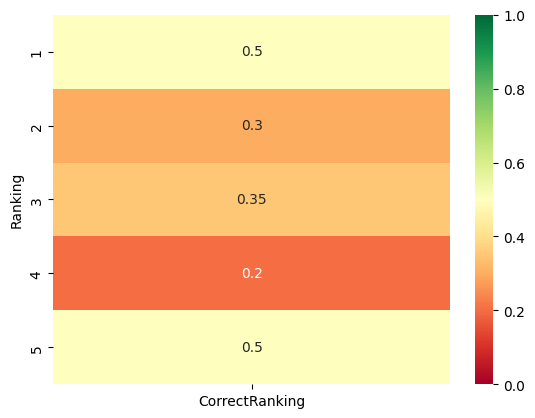

In [120]:
#visualise, wordle style ish
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(pd.DataFrame(ranking_prediction_df.groupby('Ranking')['CorrectRanking'].mean()), vmin=0, vmax = 1, cmap = 'RdYlGn', annot = True)
plt.show()

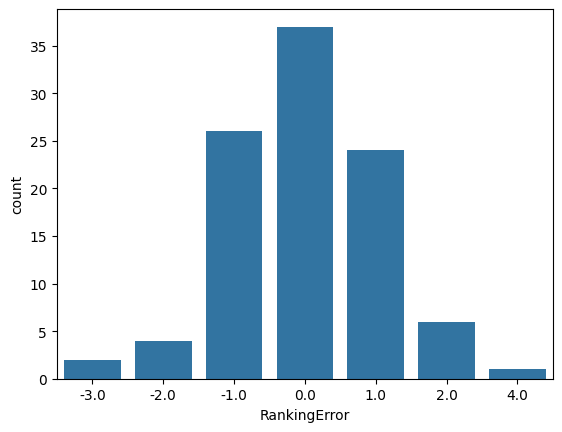

In [123]:
# Plot distribution of errors
sns.countplot(data = ranking_prediction_df, x = 'RankingError')
plt.show()

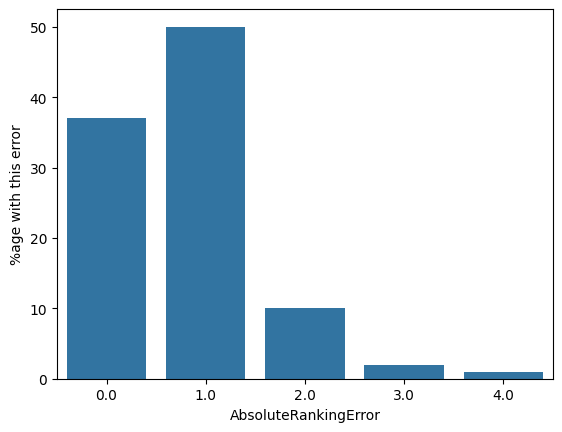

In [131]:
# Proportion falling each ranking error
ranking_prediction_df['AbsoluteRankingError'] = abs(ranking_prediction_df['RankingError'])
sns.countplot(data = ranking_prediction_df, x = 'AbsoluteRankingError', stat = 'percent')
plt.ylabel('%age with this error')
plt.show()